In [5]:
pip install keras-tuner

   ---------------------------------------- 128.9/128.9 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Trial 5 Complete [03h 55m 04s]
val_accuracy: 0.9192577600479126

Best val_accuracy So Far: 0.920762300491333
Total elapsed time: 19h 21m 45s
Epoch 1/20
859/859 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.7995

C:\Users\Siddharth\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


859/859 [==============================] - 1420s 2s/step - loss: 0.6282 - accuracy: 0.7995 - val_loss: 0.3883 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 2/20
859/859 [==============================] - 1418s 2s/step - loss: 0.3085 - accuracy: 0.9008 - val_loss: 0.3577 - val_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 3/20
859/859 [==============================] - 1435s 2s/step - loss: 0.2371 - accuracy: 0.9231 - val_loss: 0.3235 - val_accuracy: 0.9012 - lr: 1.0000e-04
Epoch 4/20
859/859 [==============================] - 1444s 2s/step - loss: 0.1963 - accuracy: 0.9369 - val_loss: 0.2996 - val_accuracy: 0.9047 - lr: 1.0000e-04
Epoch 5/20
859/859 [==============================] - 1440s 2s/step - loss: 0.1616 - accuracy: 0.9481 - val_loss: 0.2886 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 6/20
859/859 [==============================] - 1418s 2s/step - loss: 0.1353 - accuracy: 0.9582 - val_loss: 0.2920 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 7/20
859/859 [=========================

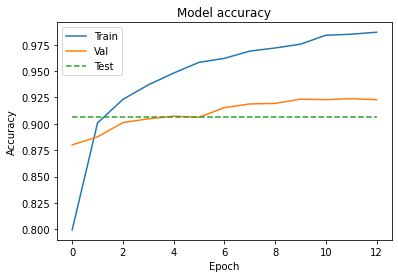

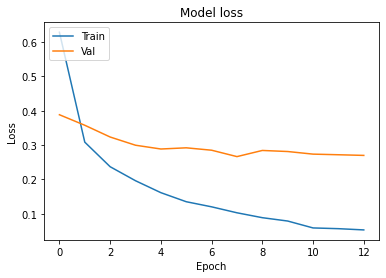

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Changed from MobileNetV2 to ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# For reproducibility, set the random seed
np.random.seed(42)
tf.random.set_seed(42)

# Define the path to the root folder of the dataset
base_dir = r'C:\Users\Siddharth\Untitled Folder\298A\train_val_test'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Setup ImageDataGenerators
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)  # Changed to resnet
val_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)    # Changed to resnet
test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)   # Changed to resnet

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Define a model-building function for Keras Tuner
def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))  # Changed to ResNet50
    base_model.trainable = False

    inputs = keras.Input(shape=(*image_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x = Dense(hp_units, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)  # Assuming 11 classes

    model = Model(inputs, outputs)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

# Perform hyperparameter tuning
tuner.search(train_generator, epochs=10, validation_data=val_generator)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_mobilenetv2_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=20,
    callbacks=callbacks
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and classification report
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

model_save_path_h5 = 'C:/Users/Siddharth/Untitled Folder/298A/train_val_test/ResNet-50_model.h5'
model.save(model_save_path_h5)
print(f"Model saved in HDF5 format at {model_save_path_h5}")

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Print the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot training & validation accuracy values
epochs_range = range(len(history.history['accuracy']))
plt.plot(epochs_range, history.history['accuracy'], label='Train')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val')
plt.plot(epochs_range, [test_accuracy]*len(epochs_range), label='Test', linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epochs_range, history.history['loss'], label='Train')
plt.plot(epochs_range, history.history['val_loss'], label='Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()